In [1]:
# import numpy as np
import pandas as pd
from IPython.display import display
import random
import math
import os 
import sys

import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count

import numpy
import torch
import torch as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
implicit_num_threads = 12
os.environ["OMP_NUM_THREADS"] = str(implicit_num_threads)
os.environ["MKL_NUM_THREADS"] = str(implicit_num_threads)
os.environ["OPENBLAS_NUM_THREADS"] = str(implicit_num_threads)
torch.set_printoptions(threshold=sys.maxsize)

In [3]:
class gomoku_game:
    def __init__(self):
        self.dim = 15 #15x15 board, can be 19x19
        self.state = np.zeros([self.dim, self.dim], dtype=np.int8)
        self.players = {'p1': 1, 'p2': 2} 
        self.isDone = False
        self.reward = {'win': 1, 'draw': 0.5, 'loss': -1}
        self.available = [] #initialize to all spots on board
        for i in range(self.dim):
            for j in range(self.dim):
                self.available.append(i + j* self.dim)
    
    def reset(self): #rev
        self.__init__()
        
    def get_available_actions(self):
        return self.available
    

    def check_game_done(self, player, last):
        def check_flat(state, i, j):
            ci = i
            while ci > 0 and state[ci][j] == state[i][j]: 
                ci -= 1
            if state[ci][j] != state[i][j]:
                left = ci + 1
            else:
                left = ci
            ri = i
            while ri < (len(state) - 1) and state[ri][j] == state[i][j]: 
                ri += 1 
            if state[ri][j] != state[i][j]:
                right = ri - 1
            else:
                right = ri
            if right - left >= 4: 
                return True 
            return False

        '''
        find length of current diag with equal values and if over 4 return true 
        '''
        def check_diag(state, i, j):
            li = i
            lj = j
            while li > 0 and lj > 0 and state[li][lj] == state[i][j]:
                li -= 1
                lj -= 1
            if state[li][lj] != state[i][j]:
                lowi = li + 1
                lowj = lj + 1
            else:
                lowi = li
                lowj = lj

            ui = i
            uj = j
            while ui < len(state) - 1 and uj < len(state) - 1 and state[ui][uj] == state[i][j]:
                ui += 1
                uj += 1
            if state[ui][uj] != state[i][j]:
                upi = ui - 1
                upj = uj - 1
            else:
                upi = ui
                upj = uj

            if upi - lowi >= 4: 
                return True
            return False

        '''
        input:
            state: board state (15x15 numpy array)
        output:
            win: boolean value of whether current player won
        '''
        
        #check diagonal
        #check horizontal
        #check vertical
        i, j = last
        # stateCp = self.state.copy()

        vert = check_flat(self.state, i, j)  #I dont believe these need to be copied
        horiz = check_flat(self.state.T, j, i)
        
        # print("hor" + str(horiz))
        # print("vert" + str(vert))
        
        #i think this should work??
        diagl = check_diag(self.state, i, j)
        diagr = check_diag(np.fliplr(self.state), i, len(self.state) -1 - j)

        diag = diagl or diagr

        return (horiz or vert) or diag


    def make_move(self, a, player):
        # check if move is valid
        i = a % self.dim
        j = int((a - i)/ self.dim)
        openSpots = self.get_available_actions()
        if a in openSpots:
            self.state[i,j] = self.players[player]
            self.available.remove(a)
        a = (i, j)
        win = self.check_game_done(player, a)

        reward = 0.
        if len(openSpots) == 0:
            reward = self.reward['draw']
            self.isDone = True
        elif win:  
            reward = self.reward['win']
            self.isDone = True

        # give feedback as new state and reward
        # return self.state.copy(), reward
        return self.state.detach().clone(), reward

env = gomoku_game()

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))


#***based on torch tutorial
class ReplayMemory(object):

    def __init__(self):
        self.memory = deque([])

    #could use *args for historical turns? 
    def push(self, *args):
        # self.memory.append(Transition(*args))
        self.memory.append(Transition(*args)) #dequeified

    def pushAll(self, TranList):
        # self.memory.extend(TranList) # list version
        self.memory = self.memory + TranList

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
memory = ReplayMemory()

In [6]:
class DQN(nn.Module):
    
    def __init__(self, outputs):
        super(DQN, self).__init__()
        # 6 by 7, 10 by 11 
        self.conv1 = nn.Conv2d(1, 128, kernel_size=7, padding=2)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=7, padding=2)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        # self.pool = nn.MaxPool2d((5,5))
        # self.conv4 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        # self.conv5 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.conv6 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.conv7 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        # linear_input_size = 6 * 7 * 32
        self.MLP1 = nn.Linear(15488, 512)
        # self.MLP2 = nn.Linear(512, 512)
        # self.MLP3 = nn.Linear(512, 512)
        self.MLP4 = nn.Linear(512, outputs)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        # x = self.pool(x)
        # x = F.leaky_relu(self.conv4(x))
        # x = F.leaky_relu(self.conv5(x))
        # x = F.leaky_relu(self.conv6(x))
        # x = F.leaky_relu(self.conv7(x))
        # flatten the feature vector except batch dimension
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.MLP1(x))
        # x = F.leaky_relu(self.MLP2(x))
        # x = F.leaky_relu(self.MLP3(x))
        return self.MLP4(x)
    

# def DQN (outputs):
#     model = nn.Sequential(
#         nn.Conv2d(1, 32, kernel_size=(7,7), padding=2), 
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         nn.Conv2d(32, 32, kernel_size=(7,7), padding=2),
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         # nn.MaxPool2d((2,2)),
#         nn.Conv2d(32, 64, kernel_size=(7,7), padding=2),
#         nn.BatchNorm2d(64),
#         nn.ReLU(),
#         # nn.MaxPool2d((2,2)),
#         nn.Flatten(),
#         nn.Linear(5184, 1024),
#         nn.ReLU(),
#         nn.Linear(1024, outputs),
#     )
#     return model

In [7]:
steps_done = 0
training_history = []

loss_sum = []

In [8]:
#params
B = 256 #batch size - 256 on smaller board size was very good
gamma = 0.9999 #0.999 or 0.9999 or decrease?
lr = 1e-2
eps_start = 0.9
eps_end = 0.05
eps_decay = 200
tau = 0.005

bSize = env.dim #board dimensions
n_actions = bSize **2


policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# target_net.eval() # set target net into eval mode
optimizer = optim.Adam(policy_net.parameters(), amsgrad=True)

In [9]:
def select_action(state, available_actions, training=True):
    current_chance = random.random()
    
    #available_actions = state.get_available_actions()
    if training:
        global steps_done
        eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1 * steps_done / eps_decay)
        # eps_threshold = eps_start + (eps_start - eps_end) * math.exp(-1 * 0)
    else:
        eps_threshold = 0
    if current_chance > eps_threshold:
    # if True:
        with torch.no_grad():
            all_probabilities = policy_net(state.detach().clone().to(
        'mps', dtype=torch.float32).unsqueeze(dim=0).unsqueeze(dim=0))[0, :] #unsqez
            potential_action_probs = [all_probabilities[a] for a in available_actions]
            return available_actions[np.argmax(torch.tensor(potential_action_probs))] #Always pick most likely - could use an additional layer of randomness for fun tho?
    else: 
        return random.choice(available_actions)

In [10]:
#Optimization of model 

def optimize_model():
    if len(memory) < B:
        return

    transitions = memory.sample(B)
    batch = Transition(*zip(*transitions))

    # state_batch, action_batch, reward_batch, next_state_batch = zip(*[(np.expand_dims(m[0], axis=0), \
    #                                     [m[1]], m[2], np.expand_dims(m[3], axis=0)) for m in transitions])


    #WORKS ON CPU
    state_batch = torch.from_numpy(numpy.asarray(batch.state, dtype=numpy.float32)).to(
        'mps', dtype=torch.float32).unsqueeze(1)
    # action_batch = torch.from_numpy(numpy.asarray(batch.action, dtype=numpy.float32)).to(
    #     'mps', dtype=torch.float32)
    tempGARBAGE1 = []
    for aa in batch.action:
        if aa is not None:
            tempGARBAGE1.append([aa]) 

    action_batch = torch.tensor(tempGARBAGE1, dtype=torch.float32, device='mps')
    reward_batch = torch.from_numpy(numpy.asarray(batch.reward, dtype=numpy.float32)).to(
        'mps', dtype=torch.float32)
    # next_batch = np.expand_dims(batch.next_state, axis=0)


    tempGARBAGE = []
    for s_ in batch.next_state:
        if s_ is not None:
            tempGARBAGE.append(s_) 

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device)
    
    non_final_next_states = torch.from_numpy(numpy.asarray(tempGARBAGE, dtype=numpy.float32)).to(
        'mps', dtype=torch.float32)
    

    state_action_values = policy_net(state_batch).gather(1, action_batch.to(
        'mps', dtype=torch.long))


    next_state_values = torch.zeros(B, device=device)
    
    with torch.no_grad():
        temp = target_net(non_final_next_states.unsqueeze(1)).max(1).values
        # temp = target_net(non_final_next_states.unsqueeze(1))
        # print(target_net(non_final_next_states.unsqueeze(1)).max(1)[0].detach())
        next_state_values[non_final_mask] = target_net(non_final_next_states.unsqueeze(1)).max(1)[0].detach()
        
        # target_net(non_final_next_states.unsqueeze(1)).max(1)
    
    # compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # print(reward_batch.unsqueeze(1))
    # print(expected_state_action_values.unsqueeze(1))

    loss_sum.append(loss)

    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    




In [11]:
# random agent
def random_agent(actions):
    return random.choice(actions)

# win rate test
def win_rate_test():
    policy_net.eval()
    EVAL_EPOCHS = 20
    win_moves_taken_list = []
    win = []
    for i in range(EVAL_EPOCHS):
        env.reset()
        win_moves_taken = 0
        state = env.state.clone()
        while not env.isDone:
            
            available_actions = env.get_available_actions()
            action = select_action(state, available_actions, training=False)
            # action = random_agent(available_actions)
            state, reward = env.make_move(action, 'p1')
            win_moves_taken += 1

            if reward == 1:
                win_moves_taken_list.append(win_moves_taken)
                win.append(1)
                break

            available_actions = env.get_available_actions()
            action = random_agent(available_actions)
            # action = select_action(state, available_actions, training=False)
            state, reward = env.make_move(action, 'p2')
    policy_net.train()
    return sum(win)/EVAL_EPOCHS, sum(win_moves_taken_list)/len(win_moves_taken_list)

In [12]:
def eligibility_trace(trans_list, lambda_trace): #is a deque
    main_val = trans_list[0][2]
    out = deque([])
    for i in range(0, len(trans_list)):
        inter = (trans_list[i][0], trans_list[i][1], main_val * (lambda_trace ** (i)), trans_list[i][3])
        out.append(inter)
        if i > 4:
            for j in range(6, len(trans_list)):
                out.append(trans_list[j])
            break

    return out

In [13]:
Ba = [32, 256, 1024] #batch size - 256 on smaller board size was very good
gammaa = [0.9, 0.9999] #0.999 or 0.9999 or decrease?
lr = 1e-2
eps_start = 0.9
eps_end = 0.05
eps_decay = 200
TARGET_UPDATEa = [20, 100]

num_episodes = 40


for Bs in Ba:
    B = Bs 
    for gammas in gammaa:
        gamma = gammas
        for TARGET_UPDATEs in TARGET_UPDATEa:
            TARGET_UPDATE = TARGET_UPDATEs
            policy_net = DQN(n_actions).to(device)
            target_net = DQN(n_actions).to(device)
            target_net.load_state_dict(policy_net.state_dict())
            target_net.eval()
            steps_done = 0
            training_history = []

            optimizer = optim.Adam(policy_net.parameters(), amsgrad=True)

            for i in range(num_episodes):                
                env.reset()
                state_p1 = env.state.clone()
                # record every 20 epochs
                # print(i)
                if i % 20 == 19:
                    win_rate, moves_taken = win_rate_test()
                    training_history.append([i + 1, win_rate, moves_taken])
                    # th = np.array(training_history)
                    # print training message every 200 epochs
                    if i % 20 == 19:
                        print('Episode {}: | win_rate: {} | moves_taken: {}'.format(i, training_history[-1][1], training_history[-1][2]))
                
                tempMem = deque([]) #Switch to deque
                lambda_trace = .2

                for t in count():
                    available_actions = env.get_available_actions()
                    action_p1 = select_action(state_p1, available_actions, True)
                    steps_done += 1
                    state_p1_, reward_p1 = env.make_move(action_p1, 'p1')

                    if env.isDone:
                        if reward_p1 == 1:
                            # reward p1 for p1's win
                            memory.push(state_p1, action_p1, 1, None)
                            #tempMem.appendleft((state_p1, action_p1, 1, None))
                        else:
                            # state action value tuple for a draw
                            memory.push(state_p1, action_p1, 0.5, None)
                            #tempMem.appendleft((state_p1, action_p1, 0.5, None))
                        
                        break
                    
                    available_actions = env.get_available_actions()
                    action_p2 = random_agent(available_actions)
                    state_p2_, reward_p2 = env.make_move(action_p2, 'p2')
                    
                    if env.isDone:
                        if reward_p2 == 1:
                            # punish p1 for (random agent) p2's win 
                            memory.push(state_p1, action_p1, -1,None)
                            #tempMem.appendleft((state_p1_, action_p1, -1,None))
                        else:
                            # state action value tuple for a draw
                            memory.push(state_p1, action_p1, 0.5, None)
                            #tempMem.appendleft((state_p1_, action_p1, 0.5, None))
                        break
                    
                    # punish for taking too long to win
                    memory.push(state_p1_, action_p1, -0.05, state_p2_)
                    # tempMem.appendleft((state_p1_, action_p1, -0.05, state_p2_))
                    state_p1 = state_p2_
                    
                # tempupdate = eligibility_trace(tempMem, lambda_trace)
                # memory.pushAll(tempupdate)
                # print(tempupdate)
                    # Perform one step of the optimization (on the policy network)
                    optimize_model()

                # update the target network, copying all weights and biases in DQN
                if i % TARGET_UPDATE == TARGET_UPDATE - 1:
                    target_net.load_state_dict(policy_net.state_dict())
           
            th = numpy.array(training_history)
            recorded = 20
            xAxislength= len(th[:, 0]) * recorded
            plt.plot(numpy.arange(xAxislength, step=recorded), th[:, 1], c='c')
            plt.legend()
            plt.title('Win Rate against random agent B =' + str(B) + ' gamma=' + str(gamma) + ' Tau=' + str(TARGET_UPDATE))
            plt.xlabel('Episode no.')
            plt.ylabel('Win rate')
            # plt.show()
            plt.savefig('Win Rate against random agent B =' + str(B) + ' gamma=' + str(gamma) + 'Tau=' + str(TARGET_UPDATE) + '.png')
            plt.clf()

            plt.plot(numpy.arange(xAxislength, step=recorded), th[:, 2], c='c')
            plt.legend()
            plt.title('Number of steps against random agent B =' + str(B) + ' gamma=' + str(gamma) + ' Tau=' + str(TARGET_UPDATE))
            plt.xlabel('Episode no.')
            plt.ylabel('Average steps taken for a win')
            # plt.show()
            plt.savefig('Number of steps against random agent B =' + str(B) + ' gamma=' + str(gamma) + 'Tau=' + str(TARGET_UPDATE) + '.png')
            plt.clf()



# path = 'Small-3Conv-1lin.pth'
# torch.save(policy_net.state_dict(), path)

print('Complete')

KeyboardInterrupt: 

In [ ]:
print(len(memory))

4997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


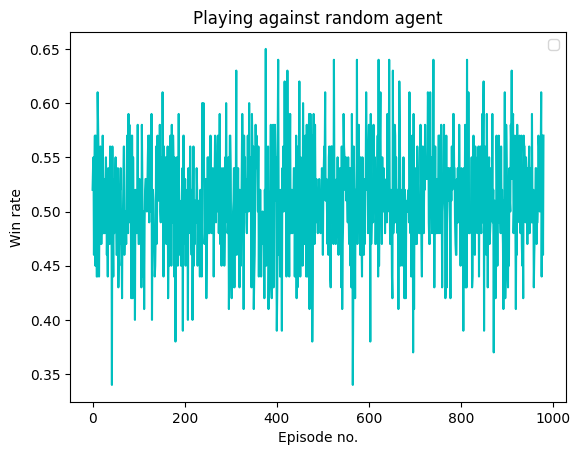

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


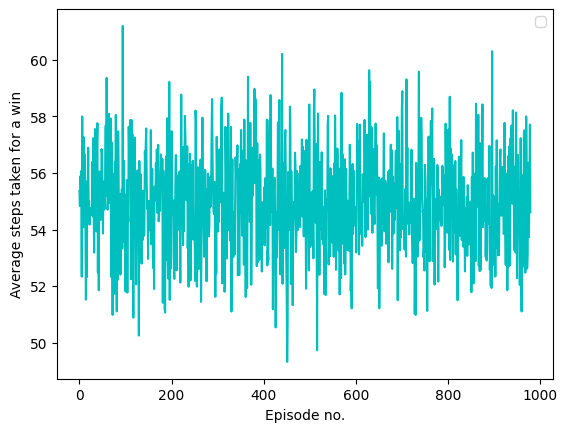

0.006528805010020733


[]

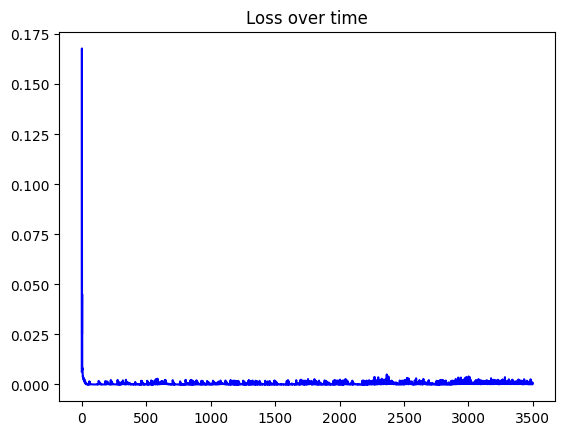

In [ ]:
th = numpy.array(training_history)
recorded = 1
xAxislength= len(th[:, 0]) * recorded
plt.plot(numpy.arange(xAxislength, step=recorded), th[:, 1], c='c')
plt.legend()
plt.title('Playing against random agent')
plt.xlabel('Episode no.')
plt.ylabel('Win rate')
plt.show()

plt.plot(numpy.arange(xAxislength, step=recorded), th[:, 2], c='c')
plt.legend()
plt.xlabel('Episode no.')
plt.ylabel('Average steps taken for a win')
plt.show()


plt.clf()
print(loss_sum[0].item())
ar = numpy.arange(len(loss_sum))
# ar = numpy.arange(400, 1000)
sece = []
for s in loss_sum:
    sece.append(s.item())
plt.plot(ar, sece, c='b')
plt.title("Loss over time")
plt.plot()